<a href="https://colab.research.google.com/github/RonBartov/American_Sign_Language_Classification/blob/main/Final_Project_ASL_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning Final Project- American Sign Language Images Classification**

In [1]:
import os
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd
from PIL import Image as Im 
from PIL import ImageOps
from google.colab import drive
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
from torchvision.utils import make_grid
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Additional Functions That Will Be Used In The Project**

In [7]:
def plot_one_iPhone_img(indicator=None, img_source=None):
  ''' Inputs:
      indicator: the letter of the label.
      img_source: path of the iPhone images folder

      Output:
      None. The function will plot an iPhone image in 3 different plots- original image, gray scale and resized grayscale
  '''
  
  img_name = "ASL_iPhone_Image_" + indicator
  print("Image Name: " + img_name + "\n")
  img_path = img_source + "/ASL_Image_" + indicator + ".jpeg"
  img_rgb = Im.open(img_path)
  img_gray = ImageOps.grayscale(img_rgb)
  resized_gray_img = img_gray.resize((28, 28))

  print("Size of the original image:", np.array(img_rgb).shape)
  print("Size of the gray image:", np.array(img_gray).shape)
  print("Size of the gray resized image:", np.array(resized_gray_img).shape)

  # Plots
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))
  axs[0].imshow(img_rgb)
  axs[0].set_title("Original Image")
  axs[1].imshow(img_gray, cmap='gray')
  axs[1].set_title("Gray Image")
  axs[2].imshow(resized_gray_img, cmap='gray')
  axs[2].set_title("Gray Resized Image")

  return None

In [6]:
def bar_graph_plot(pd_series, x_label='',y_label='',Title=''):
  '''
  Inputs:
  pd_series: pandas series of shape(N,). The names of the columns need to be an integers

  Output:
  None. The function will plot a bar plot of the pd_series
  '''
  mean = pd_series.values.mean()
  plt.bar(pd_series.index, pd_series.values)
  plt.xticks(pd_series.index, pd_series.index)
  plt.axhline(y=mean, color='red', linestyle='--')
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(Title)
  
  # add average value to plot
  plt.annotate("Average: {:.6f}".format(mean), xy=(0, mean), xycoords='data',
              xytext=(0.3, 0.85), textcoords='figure fraction',
              arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2", color='black'),
              ha='center', va='bottom')
  plt.show()
  return None

In [4]:
def process_images(imgs_path,letter_to_int_dict):
  '''
  Inputs: 
  imgs_path: path that contains .jpeg images
  letter_to_int_dict, a dictionary that maps between the chars A-Z into their corresponding int 0-25

  Output:
  df: data frame. Each row represent 28x28=784 pixels of the resized .jpeg images from the path.
  '''
  
  data = []
  for file in os.listdir(imgs_path):
    if file.endswith(".jpeg"):
      label_char = file[len("ASL_Image_"):-len(".jpeg")]
      label_num = letter_to_int_dict[label_char]
      img = cv2.imread(os.path.join(imgs_path, file))
      resized_gray_img = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), (28, 28), interpolation=cv2.INTER_AREA)
      flat_img = resized_gray_img.reshape(-1)
      flat_img = np.append(label_num, flat_img)
      data.append(flat_img)
  data = np.array(data)
  df = pd.DataFrame(data=data, columns=["label"] + [f"pixel{i+1}" for i in range(784)])
  df["label"] = df["label"].astype(int)
  return df

In [8]:
def plot_images(dataframe, int_to_letter_dict, m,n):
  '''
  Inputs:
  dataframe: contains mxn rows, each row represent a square image with 784 pixels (28x28)
  int_to_letter_dict: dictionary that maps int (label's number) to their corresponding letters {int: leter}

  Output:
  None. The function will plot a mxn grid of images obtained from datadrame's rows
  '''

  num_of_imgs = m*n
  fig, axs = plt.subplots(m, n, figsize=(10, 10))
  axs = axs.ravel()
  
  # create x and y limits for 28x28 images
  jump = 4
  limits = [i for i in range(0, 28+jump, jump)]

  # reset indexes in order to loop from 0 to 5
  df_indx_reset = dataframe.iloc[:num_of_imgs,:]
  df_indx_reset.reset_index(drop=True, inplace=True)

  for i, row in df_indx_reset.head(num_of_imgs).iterrows():
    ax = axs[i]
    ax.imshow(row[1:].values.reshape(28, 28), cmap='gray')
    ax.set_title("ASL_Image_" + int_to_letter_dict[row[0]])
    ax.axis('on')
    ax.set_xticks(limits)
    ax.set_yticks(limits[::-1])
    ax.grid(visible=True)
    ax.set_aspect('equal')

  plt.tight_layout() # adjusts the spacing between subplots and the surrounding borders
  plt.show()

  return None

# **Section 1- General Background and Goals**

Sign languages are visual languages that use hand gestures, facial expressions, and body language to convey some meaning. They are used as a means of communication by deaf and hard-of-hearing individuals in many countries around the world. Unlike spoken languages, sign languages are not based on a particular spoken language and are unique to the deaf communities in which they are used.

Despite the widespread use of sign languages, there is still much work to be done in improving communication between deaf and hearing individuals and the development of technologies that can recognize and understand sign languages is an important step towards this goal. 

**In our project**, we are exploring the use of deep learning for American Sign Language (ASL) recognition by teaching our neural network to classify between different ASL letters. The dataset we are using is the ASL MNIST dataset, which is a dataset that has been adapted to specifically focus on the recognition of American Sign Language.


###**Data Description**
Our data composed from 28x28 grayscale images (one channel images), each one represents one of the 24 american letters that **not require any motion**, i.e all the american letters except J and Z.



The data contains 34,627 images in total and it devided into the following types:

1) Test and Validation data- 27,455 images

2) Test Data- 7,172 images


In addition, the first column of the data represents the labels of the images as a numeric values. We have in total 26 american letters that their labels are the numbers 0-25 correspondingly to the order of the letters, and because we are not using the letters J and Z (which require motion as we mentioned before) we have left only with the labels 0-8 and 10-24.


###**Additional Goal**

In addition to the classification of the MNIST data itself, our goal in this project is to exemine the classification accuracy for images that were taken from our personal phones. Those images will have a different properties, due to the type of the camera, initial resolution and also the enviroment where the image were taken, thus we will expect to get lower accuracy for those king of images.


###**Using 'Notes'** 
In orded to give some clear explenations regarding specific actions or decision we make, we will add a text box with a 'Note' title everytime we would like to explain something. 

#**Section 2- Initial Preparation for Our Personal Photos**

In order to be able to work also with our personal photos in the end of the training, we first would like to transfer it from it's current shape (folders of ".jpeg" photos) into a dataframe so it will be much easier to understand and analyze it. 

For that aim, we will create two dictionaries that will be used during this project:

**1) letter_to_int_dict-** maps the chars A-Z into the integers 0-24 correspondingly

**2) int_to_letter_dict-** maps the integers 0-24 into the chars A-Z

The transformation from images-folder structure into data frame will be implemented by using our 'process_images' function (you can read its description in the function definition above)

In [9]:
# creating the dictionaries
letters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
integers = range(26)
int_to_letter_dict = dict(zip(integers,letters))
letter_to_int_dict = dict(zip(letters,integers))

In [10]:
# transforming images into dataframe

# Ron's path
iPhone_imgs_folder_path = "/content/gdrive/MyDrive/Colab Notebooks/Deep Learning Final Project- ASL/ASL_Images_From_Iphone"

# Aviv's path
# imgs_folder_path = ""

iPhone_imgs_df = process_images(iPhone_imgs_folder_path, letter_to_int_dict)
iPhone_imgs_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,5,207,208,208,208,208,210,210,211,212,...,125,179,189,187,185,185,183,182,183,184
1,2,206,207,207,207,208,208,210,211,212,...,188,185,183,182,180,180,179,179,180,181
2,1,216,216,216,217,217,218,218,220,221,...,90,148,186,185,181,180,178,178,178,180
3,0,213,213,212,212,212,213,213,213,214,...,87,82,97,144,181,190,187,186,185,185
4,24,202,203,204,204,205,205,205,205,205,...,96,93,86,71,122,173,172,172,171,167


Image Name: ASL_iPhone_Image_Y

Size of the original image: (2048, 2048, 3)
Size of the gray image: (2048, 2048)
Size of the gray resized image: (28, 28)


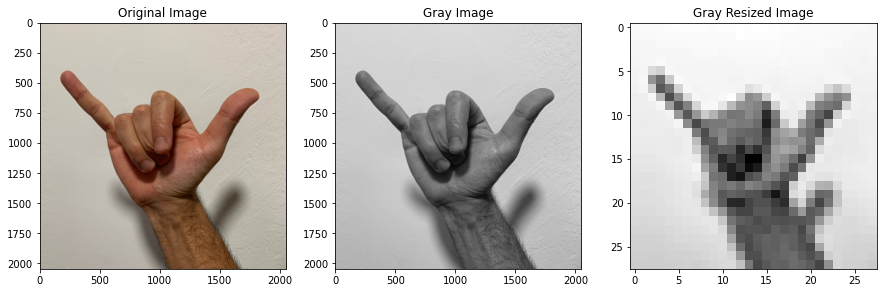

In [11]:
# plot one iPhone image to see the full image processesing step
plot_one_iPhone_img(indicator='Y', img_source=iPhone_imgs_folder_path)

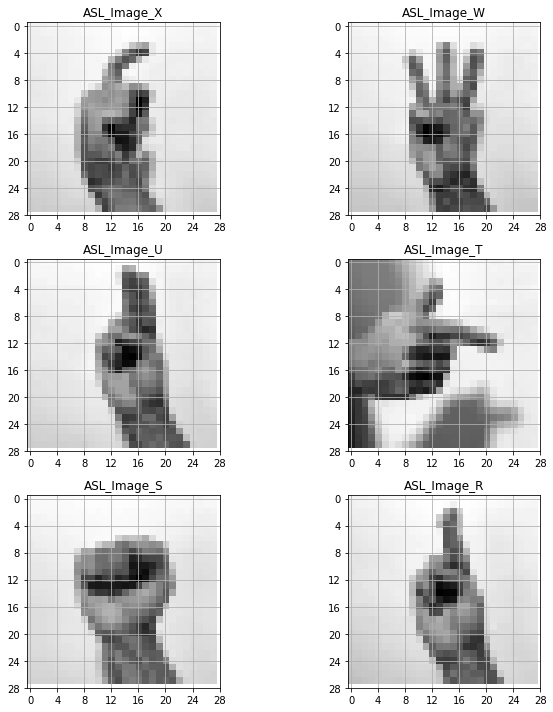

In [12]:
# plot few iPhone images as an example
m_rows = 3
n_cols = 2
start_ind = 5
iPhone_imgs_df_to_plot = iPhone_imgs_df.iloc[start_ind:start_ind+m_rows*n_cols,:]

plot_images(iPhone_imgs_df_to_plot, int_to_letter_dict,m=m_rows,n=n_cols)

#**Section 3- Importing the MNIST Data and Learning its Properties**

In order to start our training part properly, we would like to learn the data in the best way we can and to work with it in a right way according to its properties. That includes the following:

**1) High-level understanding of the data-** Checking the number of samples, classes, and the distribution of the data, such as the range of pixels values, mean and variance. In addition, we will also check wether there are missing values in the data cells.


**2) Splitting the data-** The ASL MNIST data already splitted into "train" and "test" sets, thus we will focus on splitting the "train" data into "train" and "validation" sets while trying not to change its distribution properties.


In [13]:
# Define the data paths

# Ron's paths
csv_train_val_path = "/content/gdrive/MyDrive/Colab Notebooks/Deep Learning Final Project- ASL/sign_mnist_train.zip"
csv_test_path = "/content/gdrive/MyDrive/Colab Notebooks/Deep Learning Final Project- ASL/sign_mnist_test.zip"

# Aviv's paths
# csv_train_val_path = "/content/gdrive/MyDrive/DP_course/final/data/sign_mnist_train.csv"
# csv_test_path = "/content/gdrive/MyDrive/DP_course/final/data/sign_mnist_test.csv"


In [14]:
df_train_val = pd.read_csv(csv_train_val_path)
df_test = pd.read_csv(csv_test_path)

In [15]:
# presenting few rows from the train dataframe 
df_train_val.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### **Note #1**

As we see above, each row in the data represents an image. The first column is the label value and the rest are the pixels values. Because the images are of size 28x28, then we have 784 pixels values in total.

## **1) High-level understanding of the data before splitting**

In [16]:
# data shape
print('Shape the unified training and validation set: ', df_train_val.shape)
print('Shape of samples in the test set: ', df_test.shape)

Shape the unified training and validation set:  (27455, 785)
Shape of samples in the test set:  (7172, 785)


In [17]:
# check for maximum and minimum pixels values and verify there is no missing values in the data 
print("Missing values in the unified training and validation set: ", df_train_val.isnull().sum().sum())
print("Missing values in the test set: ", df_test.isnull().sum().sum(), "\n")
print("Maximum pixel value in unified training and validation set: ", df_train_val.iloc[:,1:].max().max())
print("Minimum pixel value in unified training and validation set: ", df_train_val.iloc[:,1:].min().min())

Missing values in the unified training and validation set:  0
Missing values in the test set:  0 

Maximum pixel value in unified training and validation set:  255
Minimum pixel value in unified training and validation set:  0


In [18]:
# calculate the number of sample for each label in the unified training and validation set
count_label = df_train_val.groupby('label').size()
count_label
# count_label_percentage = count_label/len(df_train_val.axes[0])
# count_label_percentage

label
0     1126
1     1010
2     1144
3     1196
4      957
5     1204
6     1090
7     1013
8     1162
10    1114
11    1241
12    1055
13    1151
14    1196
15    1088
16    1279
17    1294
18    1199
19    1186
20    1161
21    1082
22    1225
23    1164
24    1118
dtype: int64

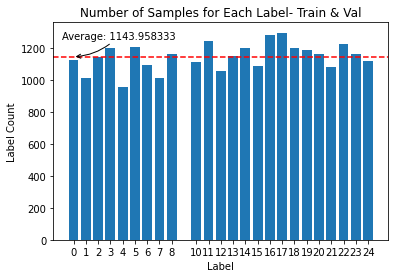

In [19]:
# presenting appearence percentage for each label in a bar plot
bar_graph_plot(count_label, x_label='Label',y_label='Label Count',Title='Number of Samples for Each Label- Train & Val')

In [20]:
# calculate the distance from the average number of images per label (in terms of percentage)
label_avg_count = count_label.sum()//24
print("Average number of samples per label is: ", label_avg_count)
label_diffrence_from_avg = abs(count_label - label_avg_count)/label_avg_count
label_diffrence_from_avg

Average number of samples per label is:  1143


label
0     0.014873
1     0.116360
2     0.000875
3     0.046369
4     0.162730
5     0.053368
6     0.046369
7     0.113736
8     0.016623
10    0.025372
11    0.085739
12    0.076990
13    0.006999
14    0.046369
15    0.048119
16    0.118985
17    0.132108
18    0.048994
19    0.037620
20    0.015748
21    0.053368
22    0.071741
23    0.018373
24    0.021872
dtype: float64

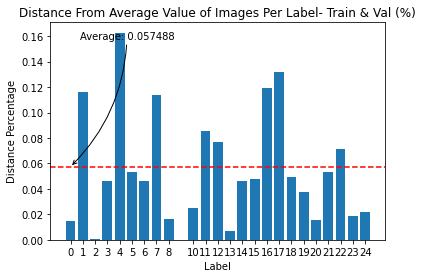

In [21]:
# presenting distance from the average number of images per label in a bar plot
bar_graph_plot(label_diffrence_from_avg, x_label='Label',y_label='Distance Percentage',Title='Distance From Average Value of Images Per Label- Train & Val (%)')

In [22]:
# calculate expectation probability distribution properties
mean_train_and_val = df_train_val.iloc[:,1:].mean(axis=0) # size (784,)
var_train_and_val = df_train_val.iloc[:,1:].var(axis=0) # size (784,)
print("For each pixel in df_train_val, the mean is around: ", mean_train_and_val.mean())
print("For each pixel in df_train_val, the variance is around: ", var_train_and_val.mean())

For each pixel in df_train_val, the mean is around:  159.2910081989452
For each pixel in df_train_val, the variance is around:  2181.1783633275427


### **Note #2**

We can see that the difference between each label's number of samples to the average number of samples is around 5% which is pretty small in respect to 1143, thus we are considering our data to be balanced in terms of training samples per label.

In addition, just to be accurate, note that the standard deviation is the square root of the variance, thus in our case we have ${σ≃46}$, which is make scence in respect to our pixels range of values. 

## **2) Splitting the data into test and validation sets and recheck the new training distribution**

In [23]:
# Split the training data into train and validation sets
val_train_factor = 0.2 # df_val_size = val_train_factor*df_train_size
df_train, df_val = train_test_split(df_train_val, test_size=val_train_factor, random_state=42)

# reset indexes
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

print('Shape of the unified training and validation set: ', df_train_val.shape)
print('Shape of the training set: ', df_train.shape)
print('Shape of the validation set: ', df_val.shape)

df_train.head()

Shape of the unified training and validation set:  (27455, 785)
Shape of the training set:  (21964, 785)
Shape of the validation set:  (5491, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,10,97,65,128,44,17,67,64,66,69,...,189,180,134,97,76,86,94,90,91,91
1,15,215,216,217,223,206,176,176,191,106,...,133,133,132,132,134,124,167,124,23,140
2,0,144,145,146,147,150,150,151,151,151,...,78,107,183,187,171,160,131,134,101,72
3,10,64,73,83,96,101,108,111,115,118,...,163,167,169,169,170,173,173,175,175,176
4,22,83,88,57,75,101,37,17,63,69,...,87,71,52,95,183,176,180,182,184,186


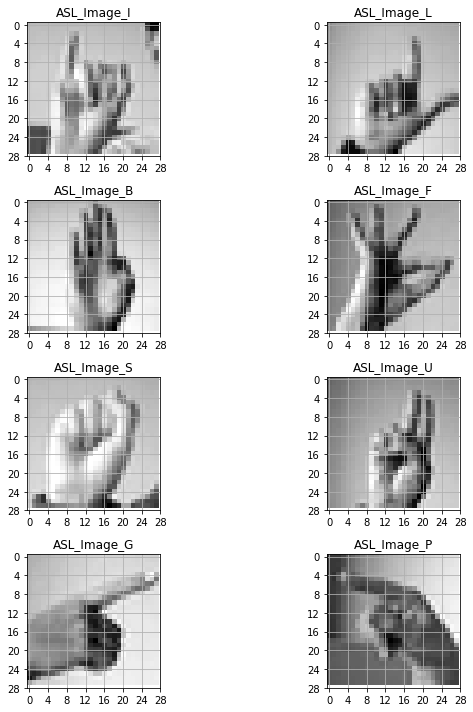

In [24]:
# plot samples from training set
m_rows = 4
n_cols = 2
start_ind = 5
df_train_to_plot = df_train.iloc[start_ind:start_ind+m_rows*n_cols,:]

plot_images(df_train_to_plot, int_to_letter_dict,m=m_rows,n=n_cols)

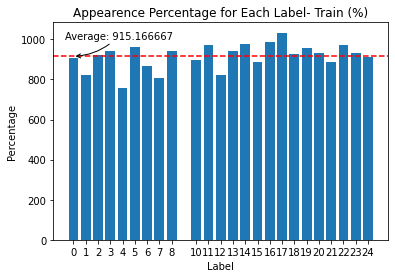

In [25]:
# calculate the appearence percentage for each label in the training set
count_label_train = df_train.groupby('label').size() 
# count_label_percentage_train = count_label_train/len(df_train.axes[0])
# count_label_percentage_train

bar_graph_plot(count_label_train, x_label='Label',y_label='Percentage',Title='Appearence Percentage for Each Label- Train (%)')

Average number of samples per label is:  915


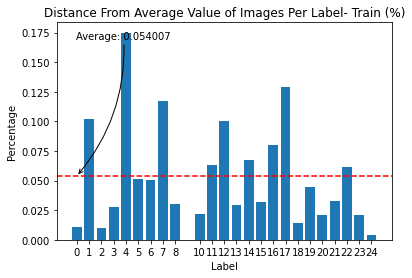

In [26]:
# calculate the distance from the average number of images per label (in terms of percentage)
label_avg_count_train = count_label_train.sum()//24
label_diffrence_from_avg_train = abs(count_label_train - label_avg_count_train)/label_avg_count_train
label_diffrence_from_avg_train

print("Average number of samples per label is: ", label_avg_count_train)
bar_graph_plot(label_diffrence_from_avg_train, x_label='Label',y_label='Percentage',Title='Distance From Average Value of Images Per Label- Train (%)')

###**Note #3**

Here we used the 'train_test_split' function in order to split the data into train and validation sets while choosing 'random_seed' to be 42 and 'val_train_factor' to be 0.2 (which means the division will bve 80% and 20%). Those values give us the ability to stay with the same division everytime we run the code cell with the same parameters. 

The parameters values we just mentioned ('random_seed' and 'val_train_factor') were choosed in such a way that they maintain the training set balanced in terms of samples per label (~5% difference from average) 

# **Section 4- Describing the Process of Learning**

Our learning process will consist the following steps: 

**1)** Creating functions that will help us to prepare our data to the training part and to evaluate the model's accuracy after finishing the training part

**2)** Creating a training function that will be responsible for parameters adaptation for a given model and input training data

**3)** Suggesting few models' architecture which will be used as the classification network

**4)** Compare the results obtained from different models and different sets of hyper-parameters. This step will also include testing the network on the images obtained from our personal phones



## **1) Preperation and Evaluation Functions Creation**
Below you can see the functions that will be part of the data processing and vizualitation during the training and analzing part.

${\circ}$ **data_loader-** Responsible on transforming the data from large and unified pixels-labels dataframe into a data loader object that contains batches (groups) of the data with separation between the pixels and the labels. In addition, due to the result we got in section 3.1, the function will normalize the pixels values by dividing in 255. The normalization will improve the performance and stability of the model and also make the model more robust to changes.

${\circ}$ **test-** Responsible foe measuring the accuracy of a fixed model parameters

${\circ}$ **plot_learning_curve-** Responsible for visualizing the accuracy and loss results

In [27]:
def data_loader(dataframe ,batch_size ,shuffle= True ):
  '''
  Inputs:
  dataframe: dataframe of size Nx785 that contains the training set. First column is the label
  batch_size: The data will be devided into data_length/batch_size groups 

  Output:
  DataLoader object that will contain the batches of our data as a set of 28x28 tensors images and their coresponding true labels
  '''
  
  # Convert the dataframe into a PyTorch tensor
  data = torch.tensor(dataframe.values, dtype=torch.float32)
  
  # Split the data into inputs (images) and targets (labels)
  inputs = data[:, 1:]
  targets = data[:, 0].long()
  
  # Normalize the inputs
  inputs = inputs / 255.0
  
  # Convert inputs into a 4D tensor for processing by the model
  inputs = inputs.view(-1, 1, 28, 28)
  
  # Create a TensorDataset from the inputs and targets
  dataset = TensorDataset(inputs, targets)
  
  # Create a DataLoader from the dataset
  return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [28]:
# example 
example_data = df_train.iloc[0:6,:] # take first 6 rows from training set (3 row images)
example_data.head(6)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,10,97,65,128,44,17,67,64,66,69,...,189,180,134,97,76,86,94,90,91,91
1,15,215,216,217,223,206,176,176,191,106,...,133,133,132,132,134,124,167,124,23,140
2,0,144,145,146,147,150,150,151,151,151,...,78,107,183,187,171,160,131,134,101,72
3,10,64,73,83,96,101,108,111,115,118,...,163,167,169,169,170,173,173,175,175,176
4,22,83,88,57,75,101,37,17,63,69,...,87,71,52,95,183,176,180,182,184,186
5,8,176,176,177,177,177,175,175,176,177,...,169,146,181,198,151,112,128,157,180,181


In [29]:
example_data_loader = data_loader(example_data,2)

# loop over the data loader in order to present it's data 
for i, data in enumerate(example_data_loader):
  inputs, labels = data
  print("Batch {}:".format(i))
  print("Inputs size:", inputs.shape)
  print("Labels:", labels)
  print("Labels size:", labels.shape, '\n')

Batch 0:
Inputs size: torch.Size([2, 1, 28, 28])
Labels: tensor([8, 0])
Labels size: torch.Size([2]) 

Batch 1:
Inputs size: torch.Size([2, 1, 28, 28])
Labels: tensor([10, 10])
Labels size: torch.Size([2]) 

Batch 2:
Inputs size: torch.Size([2, 1, 28, 28])
Labels: tensor([15, 22])
Labels size: torch.Size([2]) 



In [30]:
def test(model, test_loader):
  '''
  Input:
  model: the model to be tested
  test_loader: DataLoader object of the test set that contains the batches of samples
               (each sample of size 28x28) and their corresponding label
              
  Output:
  accuracy of the models in terms of correct classifications percentage 
  '''

  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1) # predicted is the maximum index of outputs.data
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

In [31]:
def plot_learning_curve(iters, losses, iters_sub, train_accs, val_accs):
  '''
  Output:
  Plot 1 with one curve: (iters,losses)
  Plot 2 with two curves: (iters_sub,train_accs) and (iters_sub,val_accs)
  '''
  
  plt.title("Learning Curve: Loss per Iteration")
  plt.plot(iters, losses, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Learning Curve: Accuracy per Iteration")
  plt.plot(iters_sub, train_accs*100, label="Train")
  plt.plot(iters_sub, val_accs*100, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()

## **2) Creating the Training Function**

Our training function arguments are described below, but in general we used the following architecture: 

(Enter model to training mode) ${→}$ (split data into batches) ${→}$ (enter ephocs loop) ${→}$ (enter batches loop) ${→}$ (calculate the model output) ${→}$ (calculate the model loss) ${→}$ (update model's parameters) ${→}$ (repeat until finishing ephocs loop) 

${\star}$ The calculation for the validation set were computed every 50 iterations
 

In [32]:
def train_model(train_data,val_data, model, criterion, optimizer, num_epochs = 500, batch_size= 500):
  '''
  Inputs:
  train_data: train dataframe of size Nx785
  val_data: validation dataframe of size Mx785
  model: neural network class object
  criterion: loss function 
  optimizer
  num_epochs: number of training loops over all batches
  batch_size: the training data will be devided into data_length/batch_size groups

  Outputs:
  iters: [1:num_ephocs] iteration vector
  losses: vector of size 1xnum_ephocs contain the loss of the training set every iteration
  iters_sub: [1:(num_ephocs//50)]  iteration vector
  train_accs: vector of size 1x(num_ephocs//50) contain the accuracy of the training set every 50 iteration
  val_accs: vector of size 1x(num_ephocs//50) contain the accuracy of the validation set every 50 iteration
  '''

  # enter model into train mode
  model.train()

  # create a DataLoader from the dataset
  data_train = data_loader(train_data , batch_size)
  data_val = data_loader(val_data , batch_size)

  # initialization
  n = 0
  iters, losses = [], []
  iters_sub, train_accs, val_accs  = [], [] ,[]

  # loop over all epochs 
  for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(data_train):
      images, labels = images.to(device), labels.to(device)

      # forward pass
      outputs = model(images)
      
      loss = criterion(outputs.cpu(), labels.cpu())
      #loss = F.nll_loss(outputs.cpu(), labels.cpu())

      # backpropagation and optimization
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      iters.append(n) # iteration equivalent to batch
      losses.append(float(loss)/batch_size) 
      n+=1

      if n % 50 == 0:
        iters_sub.append(n)
        train_cost = float(loss.detach().numpy())
        data_train_2 = data_loader(train_data[1:2000] , batch_size)
        train_acc = test(model, data_train_2)

        train_accs.append(train_acc)
        val_acc = test(model, data_val)
        val_accs.append(val_acc)
        print(f'Epoch [{epoch+1}/{num_epochs}] '+"Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%, Loss %f]" % (
        n, val_acc * 100, train_acc * 100, train_cost))
        #print(f'Epoch [{epoch+1}/{num_epochs}] , Iteration[{n}], Loss: {loss.item()}')
          
  print('Finished Training')
  val_accs = np.array(val_accs)
  train_accs = np.array(train_accs)
  plot_learning_curve(iters, losses, iters_sub, train_accs, val_accs)

## **3) Models Architectures**

In this task we are dealing with images clasification while the input is a set of 28x28 images and the output is one of 24 possible labels. 

As we saw on lecture 5, natural images signals typically exhibit the following properties:

${\circ}$ **Stationarity-** We can expect similar visual patterns to repeat across the image

${\circ}$ **Locality-** Nearby pixels are more correlated than points far away

<br>

In this case, we can process our data with networks that use sparsity and weight sharing:

${\circ}$ **Sparsity-** Each neuron will be connected to only a few local neurons of the previous layer

${\circ}$ **Weight Sharing-** We will use a small set of parameters multiple times across the network architecture

<br>

Neural interconnections with sparsified and shared weights basically have a property called equivariance (time-invariance in the spatial domain). 

According to what we just explained, the type of neural network  that will have the most benefits for our task will be a Convolutional Neural Network, that its trainable parameters are essentially a set of two-dimensional filters. 

Here, we will present and implement 3 different model's architecture, based on images convolutions, that we found usefull for the image classification task. 


### **Model 1- Convolutional Neural Network** 
It is a classic architecture for image classification tasks, and it consists of multiple consecutive layers:

${\circ}$ **Convolutional Layers-** Extract local features or patterns from the input data

${\circ}$ **Activation Functions-** Introduce non-linear transformations that can model complex relationships in the data.

For the hidden layers we chose ReLU because it is less susceptible to vanishing gradients in respect to Sigmoid and Tanh. For the output layer we chose the softmax function because it is the most common for multi-class classification problems.

${\circ}$ **Max Pooling Layers-** Reduce the spatial dimensions of the feature maps produced by the convolutional layers

${\circ}$ **Dropout Layers-** Regularization technique used to prevent overfitting by randomly dropping out or setting to zero some of the activations in the network

${\circ}$ **Batch Normalization Layers-** Normalize the activations of each layer, making it easier for the network to learn and also improve the stability of the network



In [33]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=75, kernel_size=(3, 3), stride=1, padding=1)
    self.batchnorm1 = nn.BatchNorm2d(75)
    self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0)
    
    self.conv2 = nn.Conv2d(in_channels=75, out_channels=50, kernel_size=(3, 3), stride=1, padding=1)
    self.dropout = nn.Dropout(0.2)
    self.batchnorm2 = nn.BatchNorm2d(50)
    self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0)
    
    self.conv3 = nn.Conv2d(in_channels=50, out_channels=25, kernel_size=(3, 3), stride=1, padding=1)
    self.batchnorm3 = nn.BatchNorm2d(25)
    self.pool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=1)
    
    self.fc1 = nn.Linear(25 * 4 * 4, 512)
    self.dropout2 = nn.Dropout(0.3)
    self.fc2 = nn.Linear(512, 25) # all our labels are in the range 0-25
    self.softmax = nn.Softmax(dim=1)
    
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.batchnorm1(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = F.relu(x)
    x = self.dropout(x)
    x = self.batchnorm2(x)
    x = self.pool2(x)

    x = self.conv3(x)
    x = F.relu(x)
    x = self.batchnorm3(x)
    x = self.pool3(x)

    x = x.view(-1, 25 * 4 * 4)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    x = F.log_softmax(x, dim=1)
    
    return x

### **Model 2- Residual Network (ResNet)** 
It is a type of neural network architecture that introduce skeep connections to help alleviate the vanishing gradient and to help the network learn residual functions, which means to capture the details of the image that were not captured by the previous layers. 

We implemented the network in two steps:

<br>

**Step 1- Defining a Residual Block class**

${\circ}$ The residual block is a sequence consists of two convolutional layers, each followed by batch normalization and ReLU activation function. After passing through those layers, the input features are added to the output. 

${\circ}$ The 'downsample' is an optional argument that is used to downsample the block's input data if the number of input channels is not equal to the number of output channels of the second convolutional layer in the block. in other words, it matches the dimensions of the input feature maps with the output feature maps in order to be able to do the summation. Practically, the downsampling is implemented by using  a convolutional layer and batch normalization. 

<br>

**Step 2- Defining the Residual Network class** 

${\circ}$ The '_make_layer' function is used in the ResNet class to create a sequence of residual blocks that make up a single layer in the network.

${\circ}$ The ResNet class is defined with one convolutional block and with four layers, each of which is a sequence of residual blocks with increasing numbers of channels. The output of the last residual block layer is passed through a fully connected layer to produce the final classification output. 

In [34]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 25):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        #self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        #x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
  
        return x

## **4) Compare the Results of the Models**

### **Training and Testing Model 1 (Convolutional Neural Network)** 

In [42]:
# create the model's object
model_conv = ConvNet()

In [44]:
# move model to GPU if available 
model_conv.to(device) ;

In [46]:
# define optimizer and loss criterion
criterion_conv = F.nll_loss
optimizer_conv = torch.optim.Adam(model_conv.parameters())

Epoch [1/3] Iter 50. [Val Acc 83%] [Train Acc 85%, Loss 0.414200]
Epoch [1/3] Iter 100. [Val Acc 98%] [Train Acc 98%, Loss 0.076136]
Epoch [1/3] Iter 150. [Val Acc 100%] [Train Acc 100%, Loss 0.006952]
Epoch [2/3] Iter 200. [Val Acc 100%] [Train Acc 100%, Loss 0.003659]
Epoch [2/3] Iter 250. [Val Acc 100%] [Train Acc 100%, Loss 0.001245]
Epoch [2/3] Iter 300. [Val Acc 100%] [Train Acc 100%, Loss 0.001273]
Epoch [3/3] Iter 350. [Val Acc 100%] [Train Acc 100%, Loss 0.000228]
Epoch [3/3] Iter 400. [Val Acc 100%] [Train Acc 100%, Loss 0.000611]
Epoch [3/3] Iter 450. [Val Acc 100%] [Train Acc 100%, Loss 0.000494]
Epoch [3/3] Iter 500. [Val Acc 100%] [Train Acc 100%, Loss 0.000146]
Finished Training


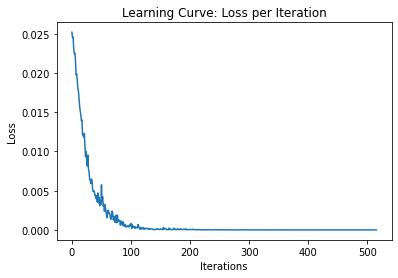

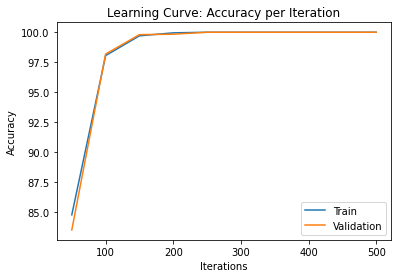

In [47]:
# train the model
train_model(df_train,df_val, model_conv, criterion_conv, optimizer_conv, num_epochs = 3, batch_size= 128)

In [56]:
# clear GPU from unneccessary data
torch.cuda.empty_cache()

In [65]:
# testing the model on the test data set
test_loader_conv = data_loader(df_test , 200 , shuffle = False)
test_accuracy_conv = test(model_conv, test_loader_conv)
test_accuracy_conv

0.9499442275515895

### **Training and Testing Model 2 (ResNet)- Option 1** 



In [57]:
# create the model's object
model_res1 = ResNet(ResidualBlock, [3, 4, 6, 3])

In [58]:
# move model to GPU if available 
model_res1.to(device) ;

In [59]:
# define optimizer and loss criterion
criterion_res1 = F.nll_loss
optimizer_res1 = torch.optim.Adam(model_res1.parameters())

Epoch [1/4] Iter 50. [Val Acc 22%] [Train Acc 21%, Loss 0.844065]
Epoch [1/4] Iter 100. [Val Acc 4%] [Train Acc 4%, Loss 3.276639]
Epoch [1/4] Iter 150. [Val Acc 4%] [Train Acc 5%, Loss 3.223940]
Epoch [1/4] Iter 200. [Val Acc 10%] [Train Acc 11%, Loss 2.957092]
Epoch [1/4] Iter 250. [Val Acc 9%] [Train Acc 10%, Loss 2.850183]
Epoch [1/4] Iter 300. [Val Acc 18%] [Train Acc 19%, Loss 2.266788]
Epoch [2/4] Iter 350. [Val Acc 28%] [Train Acc 27%, Loss 1.896108]
Epoch [2/4] Iter 400. [Val Acc 36%] [Train Acc 39%, Loss 1.629194]
Epoch [2/4] Iter 450. [Val Acc 60%] [Train Acc 61%, Loss 0.795968]
Epoch [2/4] Iter 500. [Val Acc 62%] [Train Acc 65%, Loss 0.871416]
Epoch [2/4] Iter 550. [Val Acc 73%] [Train Acc 72%, Loss 0.913133]
Epoch [2/4] Iter 600. [Val Acc 86%] [Train Acc 86%, Loss 0.955024]
Epoch [2/4] Iter 650. [Val Acc 86%] [Train Acc 88%, Loss 0.381322]
Epoch [3/4] Iter 700. [Val Acc 78%] [Train Acc 81%, Loss 0.576284]
Epoch [3/4] Iter 750. [Val Acc 90%] [Train Acc 90%, Loss 0.336801]
E

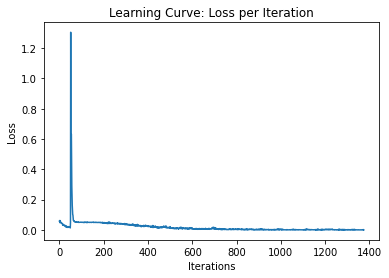

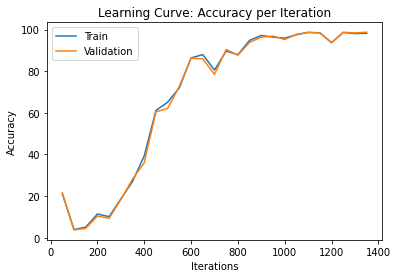

In [60]:
# train model_res1
train_model(df_train,df_val, model_res1, criterion_res1, optimizer_res1, num_epochs = 4, batch_size= 64)

In [61]:
# clear GPU from unneccessary data
torch.cuda.empty_cache()

In [66]:
# testing the model on the test data set
test_loader_res1 = data_loader(df_test , 200 , shuffle = False)
test_accuracy_res1 = test(model_res1, test_loader_res1)
test_accuracy_res1

0.8798103736754044

### **Training and Testing Model 2 (ResNet)- Option 2** 

In [67]:
# create the model's object
model_res2 = ResNet(ResidualBlock, [3, 4, 8, 3])

In [68]:
# move model to GPU if available 
model_res2.to(device) ;

In [69]:
# define optimizer and loss criterion
criterion_res2 = F.nll_loss
optimizer_res2 = torch.optim.Adam(model_res2.parameters())

Epoch [1/4] Iter 50. [Val Acc 8%] [Train Acc 8%, Loss 1.076257]
Epoch [1/4] Iter 100. [Val Acc 4%] [Train Acc 4%, Loss 3.257313]
Epoch [1/4] Iter 150. [Val Acc 7%] [Train Acc 6%, Loss 3.218900]
Epoch [1/4] Iter 200. [Val Acc 7%] [Train Acc 8%, Loss 3.088938]
Epoch [1/4] Iter 250. [Val Acc 11%] [Train Acc 12%, Loss 2.889719]
Epoch [1/4] Iter 300. [Val Acc 10%] [Train Acc 11%, Loss 2.726349]
Epoch [2/4] Iter 350. [Val Acc 10%] [Train Acc 10%, Loss 2.808794]
Epoch [2/4] Iter 400. [Val Acc 17%] [Train Acc 17%, Loss 2.189982]
Epoch [2/4] Iter 450. [Val Acc 20%] [Train Acc 21%, Loss 2.015946]
Epoch [2/4] Iter 500. [Val Acc 29%] [Train Acc 30%, Loss 1.892751]
Epoch [2/4] Iter 550. [Val Acc 31%] [Train Acc 30%, Loss 1.412518]
Epoch [2/4] Iter 600. [Val Acc 24%] [Train Acc 23%, Loss 1.571970]
Epoch [2/4] Iter 650. [Val Acc 44%] [Train Acc 47%, Loss 1.636934]
Epoch [3/4] Iter 700. [Val Acc 49%] [Train Acc 49%, Loss 1.256284]
Epoch [3/4] Iter 750. [Val Acc 55%] [Train Acc 57%, Loss 1.061946]
Epoc

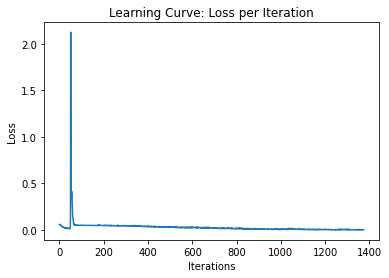

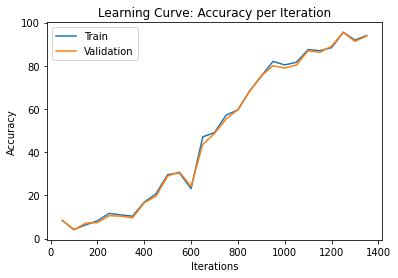

In [70]:
# train model_res2
train_model(df_train,df_val, model_res2, criterion_res2, optimizer_res2, num_epochs = 4, batch_size= 64)

In [71]:
# clear GPU from unneccessary data
torch.cuda.empty_cache()

In [72]:
# testing the model on the test data set
test_loader_res2 = data_loader(df_test , 200 , shuffle = False)
test_accuracy_res2 = test(model_res2, test_loader_res2)
test_accuracy_res2

0.8289180145008366

In [ ]:
-# from torchvision import models
# from torchsummary import summary
# summary(model.cuda(), (1,28,28))

In [73]:
# more possible criterions 
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model2.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9) 

In [74]:
# iphone test
# test_loader1 = data_loader(iPhone_imgs_df , 7)
# test1 = test(model, test_loader1)
# print(test1)

In [75]:
def predict(model , data_loader):
  model.eval()
  predictions_numbers = []
  predictions_letters = []
  with torch.no_grad():
    for images, labels in data_loader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1) # predicted is the maximum index of outputs.data
      predictions_numbers= predictions_numbers+ predicted.cpu().tolist()
      temp_letters = [int_to_letter_dict[predicted.cpu().tolist()[x]] for x in range(len(predicted.cpu().tolist()))]
      predictions_letters = predictions_letters+ temp_letters
    return predictions_numbers , predictions_letters


##Test the models

In [76]:
def predict(model , data_loader):
  model.eval()
  predictions_numbers = []
  predictions_letters = []
  with torch.no_grad():
    for images, labels in data_loader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1) # predicted is the maximum index of outputs.data
      predictions_numbers= predictions_numbers+ predicted.cpu().tolist()
      temp_letters = [int_to_letter_dict[predicted.cpu().tolist()[x]] for x in range(len(predicted.cpu().tolist()))]
      predictions_letters = predictions_letters+ temp_letters
    return predictions_numbers , predictions_letters

Model 1:

In [77]:
#first model
# predicted_numbers_1 , predicted_letters_1 = predict(model ,test_loader)
# plot_images(df_test[:4] , int_to_letter_dict , 2 , 2) 
# print(predicted_letters_1[:4])

Model 2:

In [78]:
#second model
# predicted_numbers2 , predicted_letters2 = predict(model2 ,test_loader)
# plot_images(df_test[:4] , int_to_letter_dict , 2 , 2) 
# print(predicted_letters2[:4])

Wrong prediction

In [79]:
def find_wrong_precictions(predictions , true_labels):
    wrong_predictions = []
    wrong_predictions_index = []
    for index in range(len(predictions)):
      if int(predictions[index]) != int(true_labels[index]):
         wrong_predictions.append(predictions[index])
         wrong_predictions_index.append(index)
    return wrong_predictions , wrong_predictions_index

In [80]:
true_labels = df_test['label'].tolist()

#first model
# wrong_predictions_1 , wrong_predictions_1_indexes = find_wrong_precictions(predicted_numbers_1 , true_labels)
# plot_images(df_test.iloc[wrong_predictions_1_indexes[:4]] , int_to_letter_dict , 2 , 2) 
# print('Predicted:',[int_to_letter_dict[wrong_predictions_1[x]] for x in wrong_predictions_1_indexes[:4]])
# print('True Label:',[int_to_letter_dict[true_labels[x]] for x in wrong_predictions_1_indexes[:4]])


In [ ]:
#torch.save(model, "/content/gdrive/MyDrive/DP_course/final/data/model1.pk.")